In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../util')
import helper_eval

import warnings
warnings.filterwarnings('ignore')


**Read data**

*Game Responses*

In [2]:
df_responses_calibration = pd.read_csv("../study_data/group_B_calibration.csv")
df_responses_calibration = df_responses_calibration[df_responses_calibration['game_id']>=0]

In [3]:
df_responses_calibration["nr_reds_shown"].max()

21

***Filter participants with 2 or more mistakes in attention test***

In [4]:
# read ids of filtered participants from analysis data
ids_cal = pd.read_csv("../analysis/data/filtered_ids_cal.csv")
df_responses_calibration = df_responses_calibration[~df_responses_calibration["participant_id"].isin(ids_cal['participant_id'])]

**Discretize Human Confidence**

In [5]:
conf_levels = ["very low", "low", "high", "very high","very high"]

def add_dm_conf(data): 
    divider = 100/(len(conf_levels)-1)
    data["dm_conf"] = np.array([conf_levels[int(i)] for i in np.floor(data["human_conf"]/divider)])
    #set dm_conf to high if human_conf is 50 and initial_decision is Red
    data.loc[(data["human_conf"]==50) & (data["initial_decision"]=="Red"),"dm_conf"]= "high"
    #set dm_conf to low if human_conf is 50 and initial_decision is Black
    data.loc[(data["human_conf"]==50) & (data["initial_decision"]=="Black"),"dm_conf"]= "low"

add_dm_conf(df_responses_calibration)


***Alignment Plot***

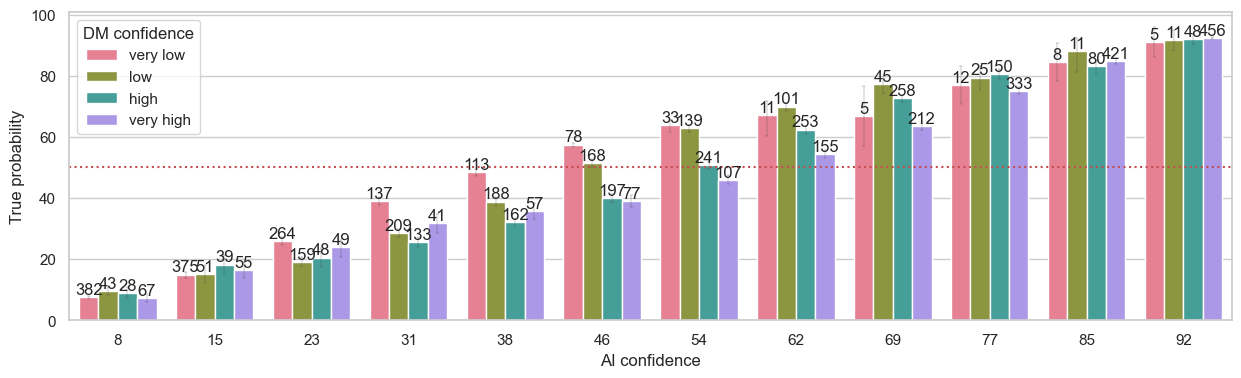

In [6]:
sns.set_context("paper")
sns.set_theme(style="whitegrid")
helper_eval.alignment_plot(df_responses_calibration, conf_levels[0:-1])

*Alignment Error*

In [7]:
dm_conf_dict = {"very low": 0, "low":1 , "high":2, "very high":3}
df_responses_calibration["dm_conf_numeric"] = df_responses_calibration.apply(lambda x: dm_conf_dict[x["dm_conf"]], axis=1)

print("Group B calibration data")
EAE, MAE = helper_eval.check_alignment(df_responses_calibration)
print("EAE: ", EAE)
print("MAE: ", MAE)


Group B calibration data
EAE:  0.00613
MAE:  0.19


***Multicalibration - Calibration+Test Split***

In [8]:
np.random.seed(34002)

*Split Data into Calibration Data and Test Data*

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_responses_calibration, test_size=0.33, random_state=42)

*Use Calibration Data as Input for the Multicalibration Algorithm*

In [10]:
sys.path.insert(0, 'calibration_algorithm')
import calibration 

hb = {}
conf_levels = ["very low", "low", "high", "very high"]
for conf in conf_levels:
    # initialize recalibrator and set number of bins
    hb[conf] = calibration.HB_binary(n_bins=5) 

    df = X_train[X_train["dm_conf"]==conf]
    proba = df["AI_conf"]/100
    y_calib = df["true_prob"]
    # recalibrate
    hb[conf].fit(proba, y_calib)


*Recalibrate Test Split with Multicalibration Algorithm*

In [11]:
df_cal = X_test.copy()

df_cal["AI_calibrated"] = df_cal.apply(lambda x: hb[x["dm_conf"]].predict_proba(np.array([x["AI_conf"]/100]))[0].round(0), axis=1)

*Alignment Plot of Test Split after Recalibration*

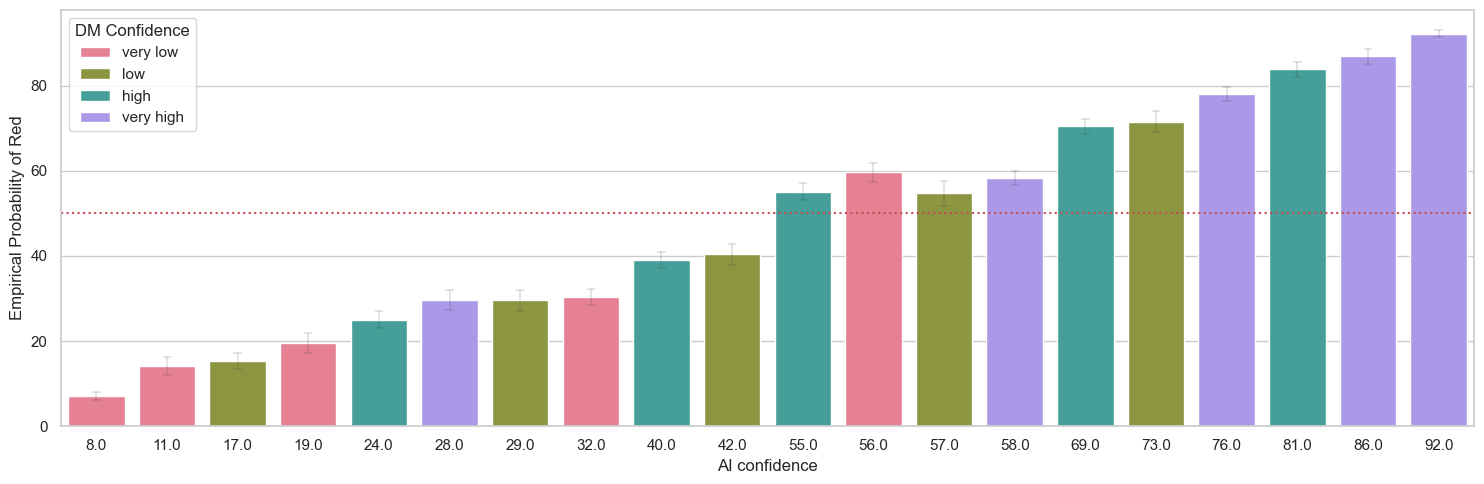

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
df_count = df_cal.pivot_table(#index='dm_conf', 
                     columns=['dm_conf','AI_calibrated'], aggfunc='count', fill_value=0, values="human_conf",dropna=False).unstack().reset_index().fillna(value=0).rename(columns={0:'count'})

ax= sns.barplot(x='AI_calibrated', y='true_prob', hue='dm_conf', estimator=np.nanmean, errorbar=('ci', 90), errwidth=.2, capsize=.12, hue_order=[ "very low", "low", "high", "very high"], data=df_cal, palette="husl")

ax.axhline(y=50, color='r', linestyle='dotted')
ax.legend(title="DM Confidence")
ax.set_ylabel("Empirical Probability of Red")
ax.set_xlabel("AI confidence")

fig.tight_layout()

plt.show()

*Alignment Error of Test Split after Recalibration*

In [13]:

df_cal["AI_conf"] = df_cal["AI_calibrated"]

print("Group B calibration data (test split)")
EAE, MAE = helper_eval.check_alignment(df_cal)
print("EAE: ", EAE)
print("MAE: ", MAE)

Group B calibration data (test split)
EAE:  0.00038
MAE:  0.05


**Multicalibration on full Calibration Data**

In [14]:
np.random.seed(34002)

In [15]:
# sys.path.insert(0, 'calibration_algorithm')
# import calibration 

hb = {}
conf_levels = ["very low", "low", "high", "very high"]
for conf in conf_levels:
    # initialize recalibrator and set number of bins
    #same sharpness as original AI
    hb[conf] = calibration.HB_binary(n_bins=5)

    df = df_responses_calibration[df_responses_calibration["dm_conf"]==conf]
    proba = df["AI_conf"]/100
    
    y_calib = df["true_prob"]
    # recalibrate
    hb[conf].fit(proba, y_calib)


*Save Multicalibration Algorithm for Recalibration of the AI during the Study*

In [16]:
hb_dict = {}
for conf in conf_levels:
    hb[conf].bin_upper_edges = np.nan_to_num( hb[conf].bin_upper_edges, posinf=1.1)
    hb_dict[conf] = hb[conf].__dict__

pd.DataFrame(hb_dict).fillna(1.9).to_json("./materials/multicalibration_alg.json", indent=4)
pd.DataFrame(hb_dict)

,very low,low,high,very high
delta,0.0,0.0,0.0,0.0
n_bins,5,5,5,5
bin_upper_edges,"[0.08000000006899707, 0.15000000003579678, 0.2...","[0.23000000006374796, 0.3100000000665663, 0.45...","[0.38000000000743167, 0.5399999999677974, 0.61...","[0.5399999999924622, 0.6900000000237311, 0.849..."
mean_pred_values,"[7.627530363637172, 12.701754384750906, 19.022...","[16.64882942983176, 27.32441471301859, 41.0167...","[24.305816132720462, 39.67636022118918, 55.629...","[28.76468358939867, 57.96513830421369, 76.3660..."
num_calibration_examples_in_bin,"[[285.0], [285.0], [285.0], [284.0], [284.0]]","[[230.0], [230.0], [230.0], [230.0], [230.0]]","[[328.0], [328.0], [327.0], [327.0], [327.0]]","[[406.0], [406.0], [406.0], [406.0], [406.0]]"
fitted,True,True,True,True
